# Google traces


In [83]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import os

In [84]:
datadir = '/home/aakahlow/GTraces/gem5/gtraces-results'

In [85]:
def getStat(filename, stat):
    #filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    #print(stat)
    #print(filename)
    try:
        with open(filename) as f:
            readlines = f.readlines()
            for l in readlines:
                if stat in l:
                    return l
            return 0.0 #for cases where stat was not found
    except: #for cases where the file was not found
        return 0.0

In [86]:
Stats = ['system.mem_ctrl.dram.avgRdBW', 'system.mem_ctrl.dram.avgWrBW', 'system.mem_ctrl.dram.busUtil']

#modes = ['gem5', 'gem5_dcache', 'gem5_dcache_old', 'gem5_dcache_all_memory']
modes = ['1p', '2p', '4p', '8p', '16p', '32p']
devices = ['ddr4_2400', 'ddr5_8400', 'hbm_2000']
#inj_rate = ['20', '40', '60']
inj_rate = ['0']
pattern = ['charlie', 'delta', 'merced', 'whiskey']
#rd_prct = ['100', '70', '0']
rd_prct = ['0']
#duration = ['10ms']
duration = ['0']
configurations = ['baseline', 'fixed', 'aggressive']

In [87]:
#if pdf v1.5 is not used the hatches in generated figs do not show up on certain pdf viewers
# this function takes care of that issue
def savepdfviasvg(fig, name, **kwargs):
    import subprocess
    fig.savefig(name+".svg", format="svg", **kwargs)
    incmd = ["inkscape", name+".svg", "--export-pdf={}.pdf".format(name),
             "--export-pdf-version=1.5"] #"--export-ignore-filters",
    subprocess.check_output(incmd)

In [88]:
rows = []

for conf in configurations:
    for pat in pattern:
        for inj in inj_rate:
            for dev in devices:
                for rds in rd_prct:
                    for dur in duration:
                        for mod in modes:
                            stats = [conf, pat, inj, dev, rds, dur, mod]
                            for stat in Stats:
                                time_file_path = '{}-{}/{}/{}/{}/stats.txt'.format(datadir, conf, mod, dev, pat)
                                ret_line = getStat(time_file_path,stat)

                                if ret_line != 0:    
                                    if dev == 'hbm_2000':
                                        stat_val = ret_line.split()[1]
                                        ret_line = getStat(time_file_path,stat.replace('dram','dram_2'))
                                        stat_val = float(stat_val) + float(ret_line.split()[1])
                                    else:
                                        stat_val = ret_line.split()[1]
                                else:
                                    stat_val = 1
                                stats.append(stat_val)

                            rows.append(stats) 


df = pd.DataFrame(rows, columns=['conf', 'pattern','inj_rate','device','rd_perct','duration','mode',
                                 'readBW', 'writeBW', 'busUtil'])

In [89]:
df['totBW'] = df['readBW'].astype(float) + df['writeBW'].astype(float)

In [90]:
#print(df[(df['pattern']=='charlie') & (df['device']=='ddr4_2400')])

In [91]:
def doplot_stat(mode, inj, duration, rd_pct, conf, stat):   
    i = 0
    
    for p, pat in enumerate(pattern):
        
        for dv, dev in enumerate(devices):
            
            d = df[(df['pattern']==pat) & (df['inj_rate']==inj) & (df['duration']==duration) & 
                  (df['mode']==mode) & (df['rd_perct']==rd_pct) & (df['device']==dev) & (df['conf']==conf)]
            
            
            if stat == 'readBW' or stat == 'writeBW' or stat == 'totBW':
                #print(float(d[stat].iloc[0]))
                plt.bar(i, float(d[stat].iloc[0])/(1000), color='C'+str(dv))    
            else:
                plt.bar(i, float(d[stat].iloc[0]), color='C'+str(dv))
            
            i = i+1

        i = i+1
                    
    for i,pfrm in enumerate(['ddr4_2400', 'ddr5_8400', 'hbm_2000']):
        plt.bar(0,0,color='C'+str(i), label=pfrm)
    plt.xticks([1,5,9,13], ['charlie', 'delta', 'merced', 'whiskey'], rotation=0, ha='center',fontsize=8)

In [92]:
def doplot_curve(stat, bench, conf, norm=False):   
    i = 0
    
    ddr4 = []
    ddr5 = []
    hbm2 = []
    
    for j,dev in enumerate(devices):
        for m,mode in enumerate(modes):
            #print(bench)    
            d = df[(df['pattern']==bench) & (df['inj_rate']=='0') & (df['duration']=='0') & 
                  (df['mode']==mode) & (df['rd_perct']=='0') & (df['device']==dev) & (df['conf']==conf)]
            
            if dev == 'ddr4_2400':
                ddr4.append(float(d[stat].iloc[0])/(1000))
            elif dev == 'ddr5_8400':
                ddr5.append(float(d[stat].iloc[0])/(1000))
            elif dev == 'hbm_2000':
                hbm2.append(float(d[stat].iloc[0])/(1000))
                
    
    plt.plot(modes, ddr4, marker='x', color='C'+str(0), linewidth=1.3, markersize=3)
    plt.plot(modes, ddr5, marker='o', color='C'+str(1), linewidth=1.3, markersize=3)
    plt.plot(modes, hbm2, marker='s', color='C'+str(2), linewidth=1.3, markersize=3)
    
    for i,pfrm in enumerate(['ddr4', 'ddr5', 'hbm2']):
        plt.bar(0,0,color='C'+str(i), label=pfrm)
    #plt.xticks((np.arange(len(bench_2_use))*3)+0.5, bench_2_use, rotation=80, ha='center',fontsize=11)

In [93]:
def plot_conf(conf, ylimit):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 8
    fig_size[1] = 4

    plt.figure()

    plt.subplot(2, 2, 1)
    doplot_curve('totBW', 'charlie', conf)
    plt.ylabel('BW (GB/s)')
    plt.xlabel('Number of players')
    plt.legend(loc='best', ncol=1, prop={'size': 7}, frameon=0)
    plt.title('charlie')
    plt.ylim(ymax=ylimit)
    plt.tight_layout()

    plt.subplot(2, 2, 2)
    doplot_curve('totBW', 'delta', conf)
    plt.ylabel('BW (GB/s)')
    plt.xlabel('Number of players')
    plt.legend(loc='best', ncol=1, prop={'size': 7}, frameon=0)
    plt.title('delta')
    plt.ylim(ymax=ylimit)
    plt.tight_layout()


    plt.subplot(2, 2, 3)
    doplot_curve('totBW', 'merced', conf)
    plt.ylabel('BW (GB/s)')
    plt.xlabel('Number of players')
    plt.legend(loc='best', ncol=1, prop={'size': 7}, frameon=0)
    plt.title('merced')
    plt.ylim(ymax=ylimit)
    plt.tight_layout()

    plt.subplot(2, 2, 4)
    doplot_curve('totBW', 'whiskey', conf)
    plt.ylabel('BW (GB/s)')
    plt.xlabel('Number of players')
    plt.legend(loc='best', ncol=1, prop={'size': 7}, frameon=0)
    plt.title('whiskey')
    plt.ylim(ymax=ylimit)
    plt.tight_layout()


<IPython.core.display.Javascript object>


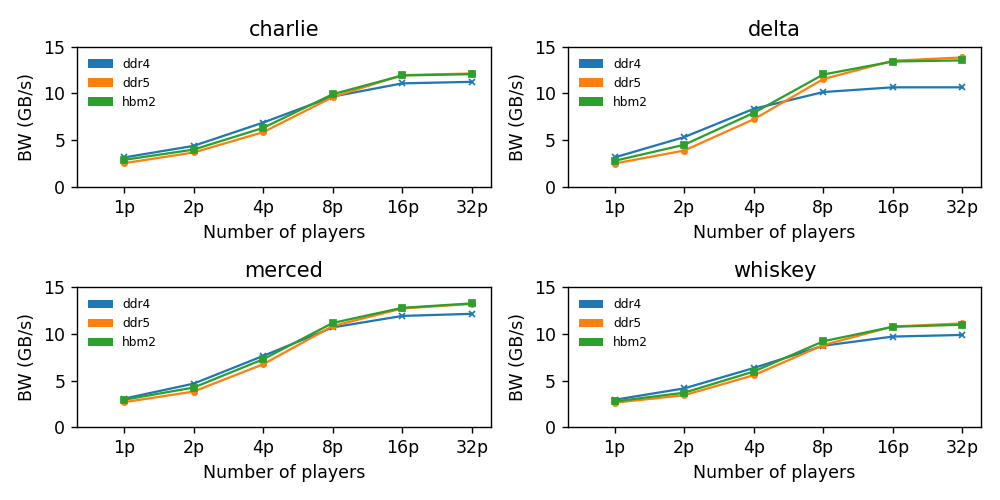

In [94]:
plot_conf('baseline', 15)

<IPython.core.display.Javascript object>


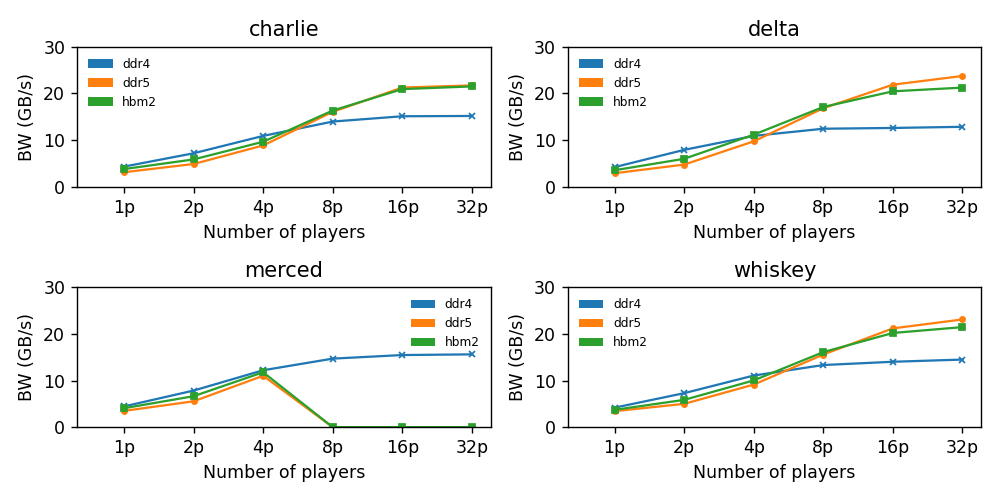

In [95]:
plot_conf('fixed', 30)

<IPython.core.display.Javascript object>


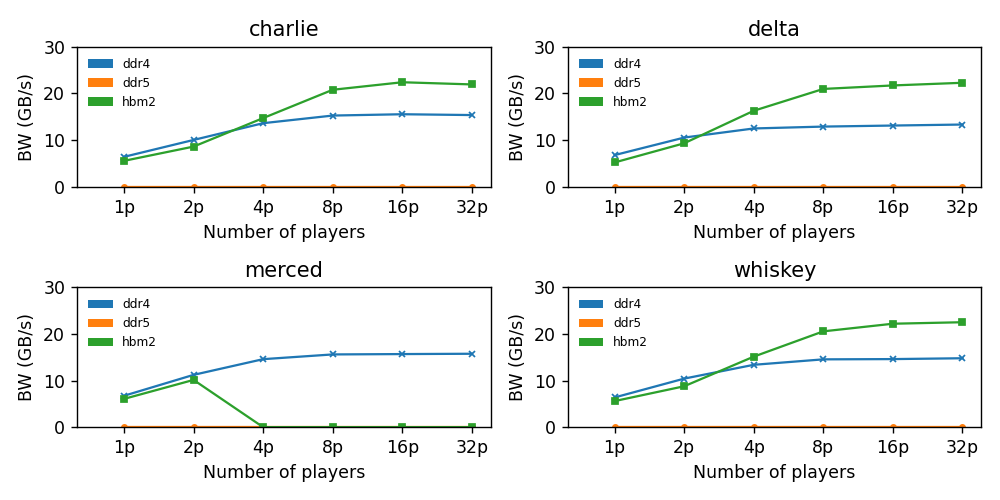

In [96]:
plot_conf('aggressive', 30)

<IPython.core.display.Javascript object>


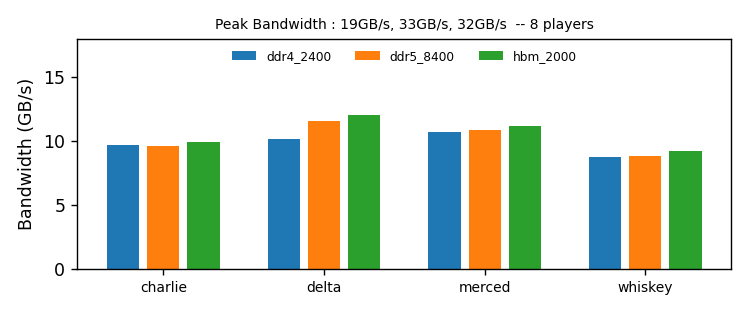

In [98]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('8p', '0', '0', '0', 'baseline', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=18)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
plt.title('Peak Bandwidth : 19GB/s, 33GB/s, 32GB/s  -- 8 players', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


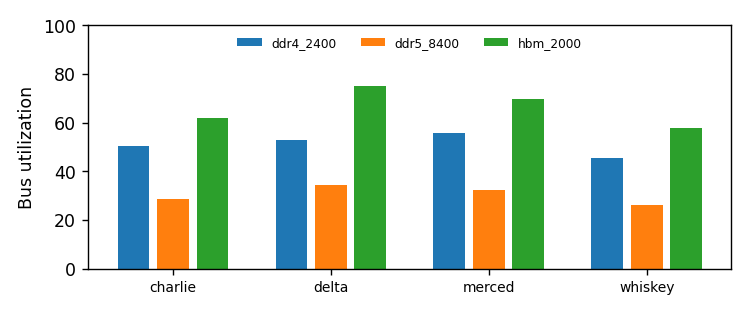

In [101]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('8p', '0', '0', '0', 'baseline', 'busUtil')

plt.ylabel('Bus utilization')
plt.ylim(ymax=100)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
#plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- DDR4 --- inj : 60GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


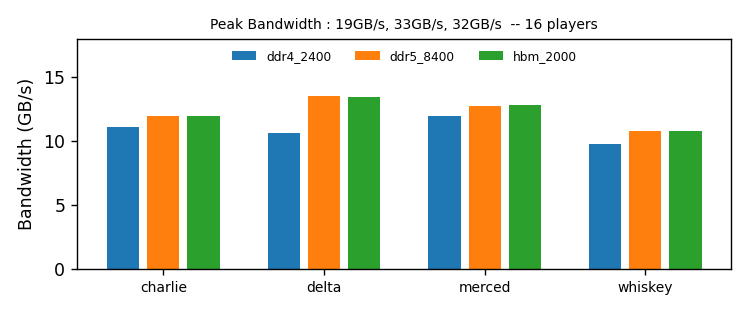

In [102]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('16p', '0', '0', '0', 'baseline', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=18)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
plt.title('Peak Bandwidth : 19GB/s, 33GB/s, 32GB/s  -- 16 players', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


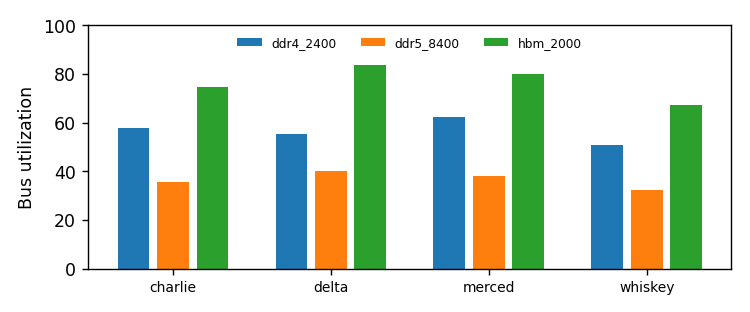

In [103]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('16p', '0', '0', '0', 'baseline', 'busUtil')

plt.ylabel('Bus utilization')
plt.ylim(ymax=100)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
#plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- DDR4 --- inj : 60GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")